# Currency Pair Experiment Example

In this notebook, we'll walk through fitting a quantum circuit Born machine (QCBM) to currency pair data as seen in _Quantum versus classical generative modelling in finance_[<sup id=back>1</sup>](#fn).

First, some imports.

In [33]:
%matplotlib inline

from pathlib import Path
import sys
sys.executable
from tempfile import TemporaryDirectory

from IPython.display import Image
from matplotlib.pyplot import subplots
from numpy import loadtxt
from pandas import read_csv
from seaborn import kdeplot

from currency_pair_loader import CurrencyPairLoader
from qcbm.experiment import main
from qcbm import extra

extra.set_theme()

ModuleNotFoundError: No module named 'currency_pair_loader'

The paper works with currency pair data, a financial dataset which "contains 5070 samples of daily log-returns of 4 currency pairs between 1999–2019;" see the figure below.
Given data from this dataset, we wish to generate synthetic data that resembles the ground truth as well as possible.
As the paper puts it,

> In the age of big data, possessing high-quality data can offer significant competitive advantage to institutions who utilize machine learning in their core business operations such as Facebook, Google and Amazon. However, for many organizations high-quality data can be scarce… Hence, high-quality data can be expensive or even impossible to obtain especially for machine learning applications at industrial scales. Synthetic data generation … allows users to overcome data scarcity, avoid privacy issues, and overcome over-fitting problems at lower costs.

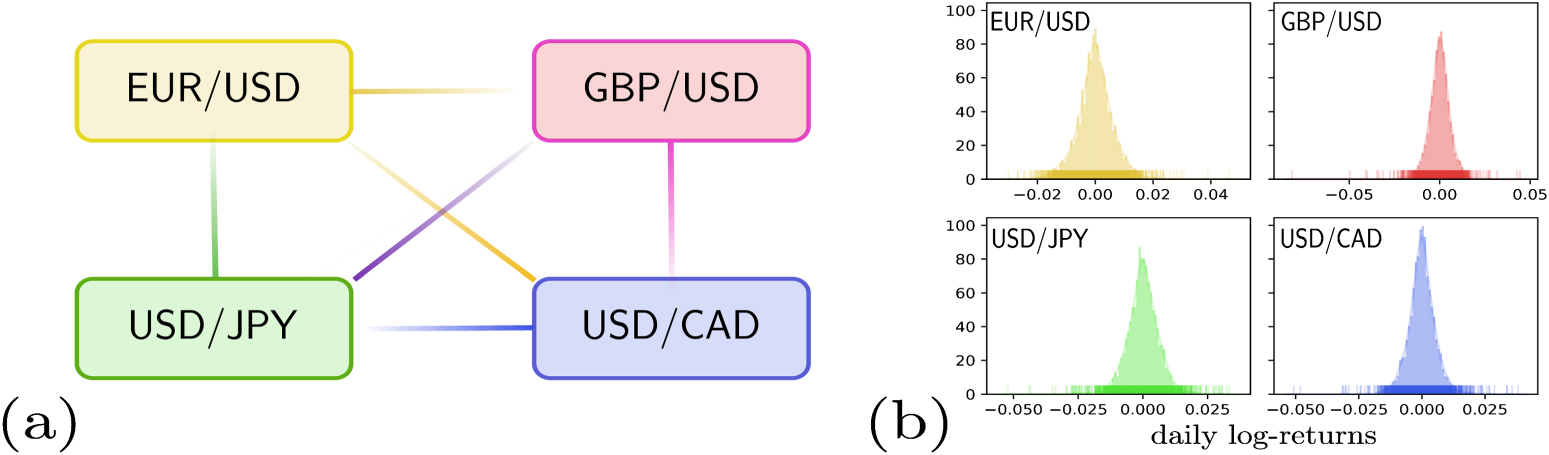

In [2]:
Image("../doc/data.jpg", width=600)

"Currency pairs" from _Quantum versus classical generative modelling in finance_[<sup>1</sup>](#fn) by Coyle et. al. is licensed under [CC BY 4.0](https://creativecommons.org/licenses/by/4.0/).

Our data will be encoded as bitstrings, collections of `0`s and `1`s of a fixed length.
The paper compares two generative models, a quantum circuit Born machine (more on that in a moment) and a classical restricted Boltzmann machine.
Given true input data and a certain amount of training iterations, both models are then asked to generate synthetic data samples which are compared to the original true data.

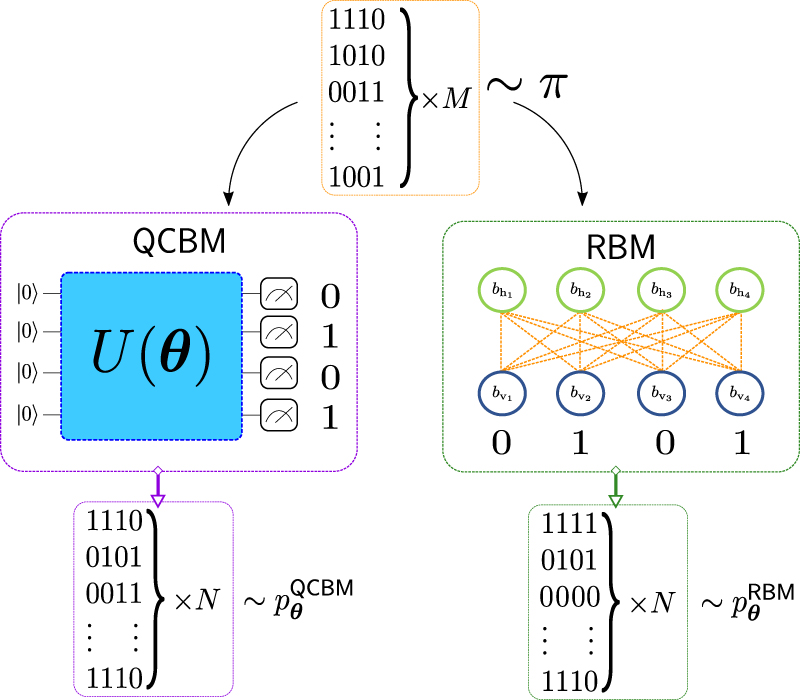

In [3]:
Image("../doc/generative.jpg", width=500)

"SDG by a QCBM versus a RBM for binary strings of length 4\" from _Quantum versus classical generative modelling in finance_[<sup>1</sup>](#fn) by Coyle et. al. is licensed under [CC BY 4.0](https://creativecommons.org/licenses/by/4.0/).

Rather than look at long strings of zeros and ones, here's a plot that shows the true data's bitstrings, where the darker hue corresponds to a `0` and the lighter to `1`.
The topmost bits (labeled `5` and `4`) tend to stay constant, while the lower bits vary more rapidly.

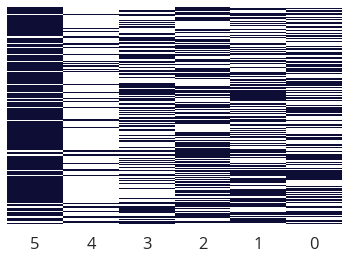

In [4]:
true_data = CurrencyPairLoader(
    number_of_currency_pairs=1,
    bits_per_currency_pair=6,
    number_samples=1000
).load()
extra.bitstring_plot(true_data);

A quantum circuit Born machine (or Born machine or QCBM) is a quantum circuit consisting of three layers of parameterized one-qubit gates (`RY`) for rotation with two layers of two-qubit gates (`CNOT`) interspersed for entanglement.
Given training data, we attempt to learn the correct parameters to generate synthetic data that mimics the training data as closely as possible, where we measure "closely" by Sinkhorn divergence, a geometric measure of the difference between statistical distributions; this will be our loss function during training, as the QCBM attempts to generate data with as low Sinkhorn divergence from the true distribution as possible.
Once training is complete, we assess the model fit by running a discriminator—a binary classifier, we use a random forest—on the samples generated during each training iteration and assess the discriminator error (1 - accuracy score).

Rather than write all the code for this model from scratch, we'll use the `qcbm` package, a Python repository developed by Rigetti Computing. Here's a layout of the current state of the repository:

```
qcbm
├── adam.py                        Adam optimizer, used for updating parameters during training
├── born_machine.py                Core Born machine implementation
├── currency_pair_loader.py        Loads currency pair data
├── currency_pairs.csv.gz          Raw data processed by currency_pair_loader
├── discriminator.py               Random forest discriminator for discerning true from synthetic data
├── experiment.py                  Main entry point for a currency pairs experiment
├── extra.py                       Extra visualization utilities
├── sinkhorn.py                    Sinkhorn divergence, our training loss function
└── training_loop.py               Encapsulates the training iterations
```

Besides the definition of `true_data` above via `qcbm.currency_pair_loader` and a few plotting extras, we'll use `qcbm.experiment.main`, the main entry point for running a currency pairs experiment.

For this demonstration, we'll use a 6 qubit quantum virtual machine (QVM).

Here's a schematic of our QCBM circuit.
Each of our six qubits start off in the zero state $\vert0\rangle$; we pass them through alternating layers of `RY` rotations and `CNOT` entangling gates, then collect measurements at the end.
During training, we update the parameters of the rotations to try to make the distribution of the bitstrings we measure match that of the training data as closely as possible, minimizing Sinkhorn divergence.

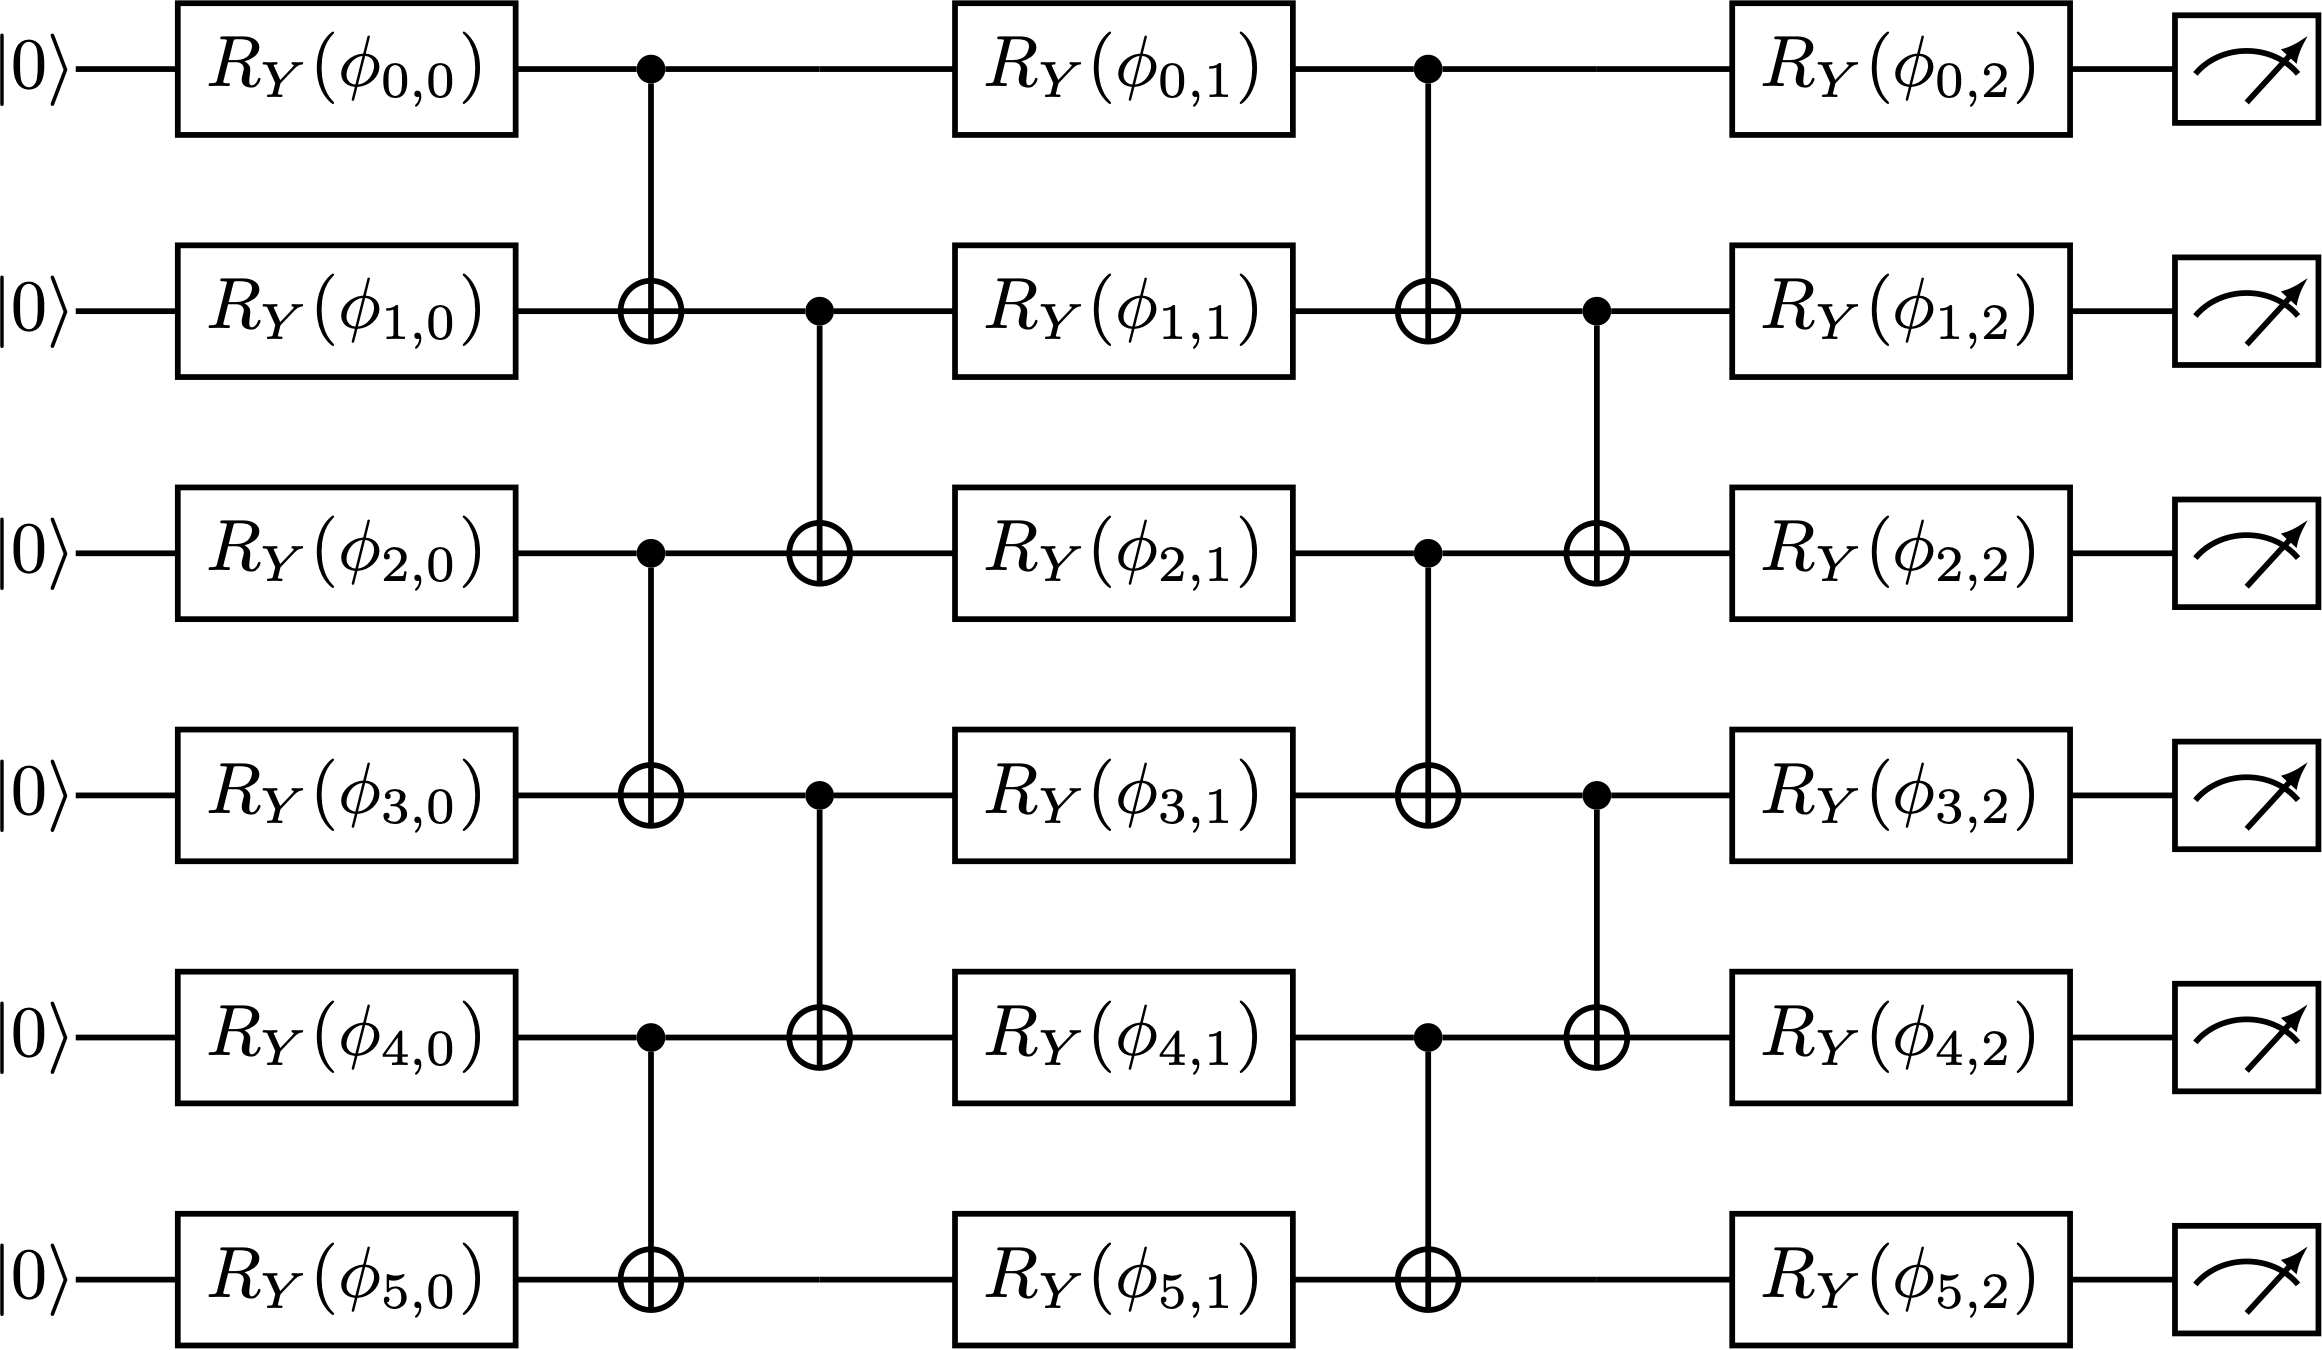

In [5]:
Image("../doc/born_circuit.png", width=600)

Because `qcbm.experiment.main` saves a bunch of CSV files in case you wish to perform further analysis, we'll put them in a temporary directory and load just what we want (the last samples and the training report) so we can look at them after the temporary directory is reclaimed.

In [6]:
with TemporaryDirectory() as save_dir:
    main(qc_name="6q-qvm", save_dir=save_dir, qubits=6)
    sd = Path(save_dir)
    samples = sorted((sd / "samples").glob("*"), key=lambda p: int(p.stem))
    final_samples = loadtxt(samples[-1], delimiter=",", dtype=int)
    report = read_csv(sd / "report.csv")

discriminating: 100%|██████████| 300/300 [00:44<00:00,  6.75it/s]


From the above training, we've loaded the final samples and the training report.
Let's examine the former first, plotting the training loss and discriminator error.
We can see that training loss gets close to zero, which means that according to Sinkhorn divergence, the samples coming from our QCBM look very much like the training samples.
Moreover, the discriminator error is roughly one half, indicating that the random forest discriminator has a hard time telling the true and synthetic data apart.

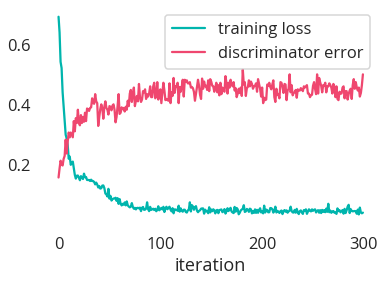

In [7]:
report[["training loss", "discriminator error"]].plot(
    color=[extra.TEAL, extra.MAGENTA],
    xlabel="iteration"
);

We can also compare the final synthetic data to the true data by eyeball, using the same bitstring plotting setup as previously.
Similar to the true data, the top bits of the synthetic data remain mostly constant, while the lower ones vary more rapidly.

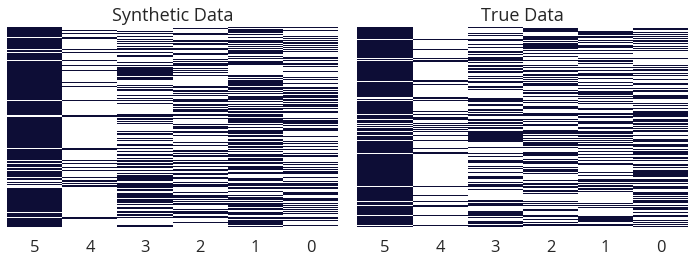

In [8]:
figure, axes = subplots(1, 2, figsize=(10, 4))
extra.bitstring_plot(final_samples, ax=axes[0])
axes[0].set_title("Synthetic Data");
extra.bitstring_plot(true_data, ax=axes[1])
axes[1].set_title("True Data")
figure.tight_layout();

As a final point, there's another factor to consider besides data quality when it comes to synthetic data generation.
Especially in fast-moving fields like finance, the amount of time it takes to generate synthetic data is also paramount.

Looking at the time sampling took on my laptop, most rounds spent about 0.4 to 0.5 seconds collecting samples from the QVM.
However, this was only with 6 qubits, which is simulatable by classical computers (like my laptop).
As the number of qubits grows, the computational power required for simulation grows exponentially.

In a benchmarking exercise in early 2021, Rigetti ran an 11 qubit QCBM on our quantum processing unit (QPU) hardware and on a competitor's.
Our hardware took less than 35 seconds per round, while a single round took more than an hour to get results on the other setup.

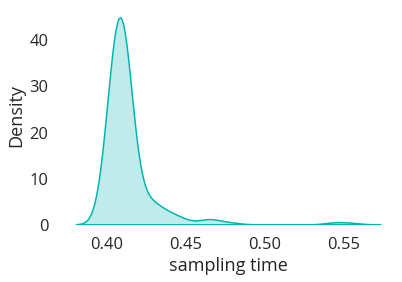

In [9]:
kdeplot(data=report, x="sampling time", color=extra.TEAL, fill=True);

[<sup id=#fn>1</sup>](#back) _Quantum versus classical generative modelling in finance_, Brian Coyle et. al., 2021 Quantum Sci. Technol. 6 024013, https://iopscience.iop.org/article/10.1088/2058-9565/abd3db</span>